In [77]:
#@title 1. IMPORT LIBRARY

# Data processing
import pandas as pd
import numpy as np


# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Evaluasi
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Baseline model
from sklearn.linear_model import LogisticRegression

# Advanced model
from sklearn.ensemble import RandomForestClassifier

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout


In [78]:
#@title 2. LOAD DATASET

df = pd.read_csv("/content/ObesityDataSet_raw_and_data_sinthetic.csv")
df.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [79]:
#@title 3. DATA CLEANING

# Cek missing values
print("Missing values per kolom:")
print(df.isnull().sum())

# Cek duplikasi
print("\nJumlah duplikasi:", df.duplicated().sum())



Missing values per kolom:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

Jumlah duplikasi: 24


In [80]:
df = df.drop_duplicates()


In [81]:
print("\nJumlah duplikasi:", df.duplicated().sum())


Jumlah duplikasi: 0


In [82]:
#@title 4. FEATURE ENGINEERING
# 1. BMI: Body Mass Index = Weight / Height^2
df["BMI"] = df["Weight"] / (df["Height"]**2)

# 2. Age Group (Teen / Adult / Senior)
df["Age_Group"] = pd.cut(
    df["Age"],
    bins=[0, 18, 40, 100],
    labels=["Teen", "Adult", "Senior"]
)

# 3. Screen Time Level untuk TUE
df["ScreenTime_Level"] = pd.cut(
    df["TUE"],
    bins=[0, 1, 3, 10],
    labels=["Low", "Medium", "High"]
)

# 4. Health Behavior Index = Aktivitas + Kontrol Porsi - Konsumsi Air
df["Health_Behavior_Index"] = df["FCVC"] + df["FAF"] - df["CH2O"]

# Menampilkan dataset setelah feature engineering
df.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Age_Group,ScreenTime_Level,Health_Behavior_Index
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,...,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.386526,Adult,Low,0.0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,...,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.238227,Adult,NaN,3.0
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,...,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.765432,Adult,Low,2.0
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,...,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.851852,Adult,NaN,3.0
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,...,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.342381,Adult,NaN,0.0


In [83]:
#@title 5. ENCODING (LABEL ENCODER)
# Ambil kolom kategorikal (object & category)
categorical_cols = df.select_dtypes(include=["object", "category"]).columns

encoder = LabelEncoder()

# Encode setiap kolom kategorikal
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])


In [84]:
#@title 6. SCALING
scaler = MinMaxScaler()

X = df.drop("NObeyesdad", axis=1)
y = df["NObeyesdad"]

# Scaling fitur numerik
X_scaled = scaler.fit_transform(X)


In [85]:
#@title 7. TRAIN - TEST SPLIT (STRATIFIED)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2, #untuk testnya kita buat 20% aja
    random_state=42,
    stratify=y   # menjaga distribusi kelas
)


In [86]:
#@title Baseline Model
baseline = LogisticRegression(max_iter=300)

import time
start = time.time()
baseline.fit(X_train, y_train)
end = time.time()

print("Training time (Logistic Regression):", end - start, "seconds")


Training time (Logistic Regression): 0.09953904151916504 seconds


In [87]:
from sklearn.ensemble import RandomForestClassifier
import time

# 1) Definisikan model Random Forest
rf = RandomForestClassifier(
    n_estimators=250,
    random_state=42
)

# 2) Training + hitung waktu
start = time.time()
rf.fit(X_train, y_train)
end = time.time()

print("Training time (Random Forest):", end - start, "seconds")


Training time (Random Forest): 0.786156415939331 seconds


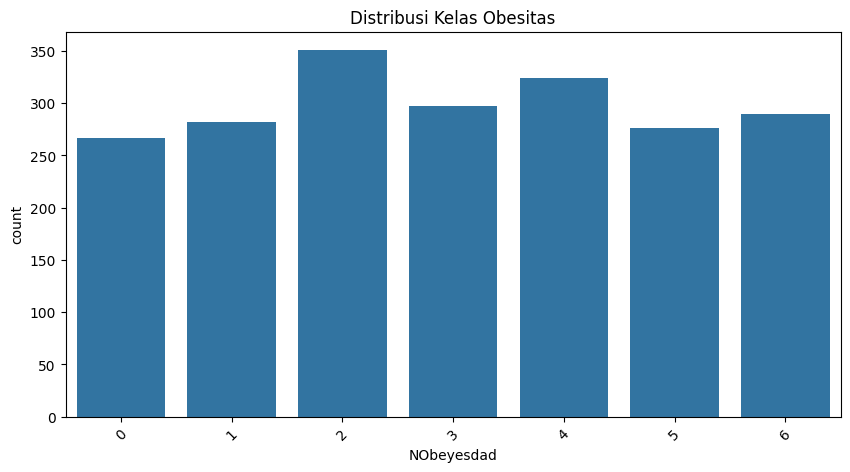

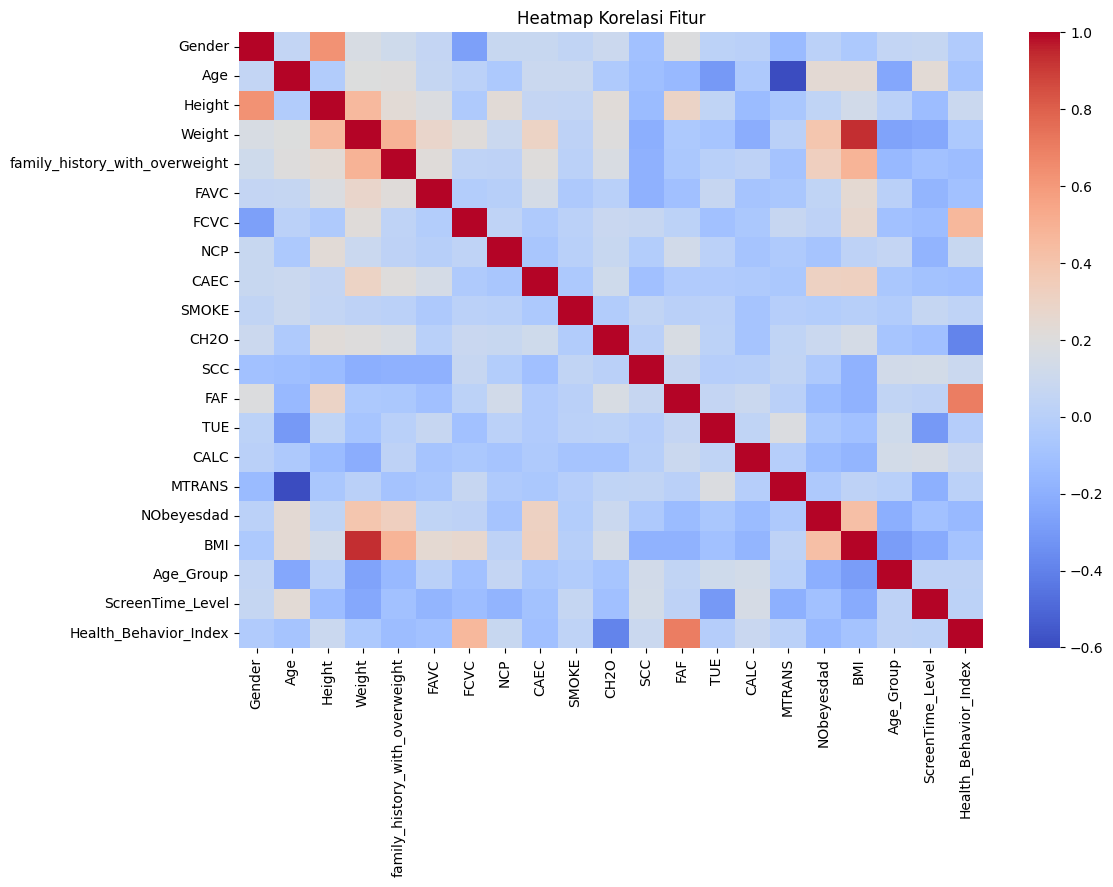

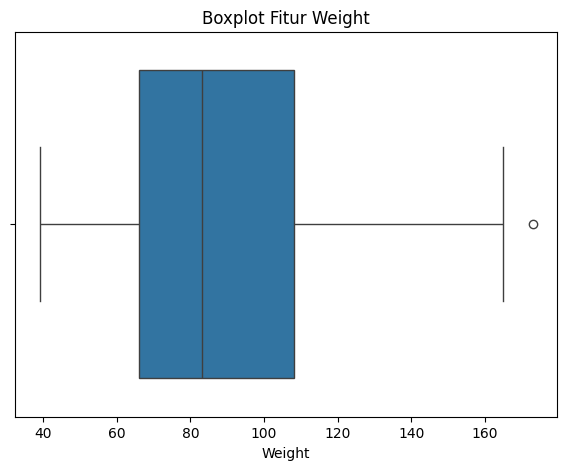

In [88]:
#@title 8. EDA VISUALISASI
#Visualisasi 1: Distribusi kelas
plt.figure(figsize=(10,5))
sns.countplot(x=df["NObeyesdad"])
plt.title("Distribusi Kelas Obesitas")
plt.xticks(rotation=45)
plt.show()

#visualisasi 2: Heatmap korelasi
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Heatmap Korelasi Fitur")
plt.show()

#visualisasi 3: Boxplot Weight
plt.figure(figsize=(7,5))
sns.boxplot(x=df["Weight"])
plt.title("Boxplot Fitur Weight")
plt.show()


In [89]:
#@title 9. BASELINE MODEL (LOGISTIC REGRESSION)

baseline = LogisticRegression(max_iter=300)
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)

print("=== Baseline Model (Logistic Regression) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base))


=== Baseline Model (Logistic Regression) ===
Accuracy: 0.7822966507177034
              precision    recall  f1-score   support

           0       0.78      0.89      0.83        53
           1       0.69      0.54      0.61        57
           2       0.74      0.73      0.73        70
           3       0.81      1.00      0.90        60
           4       0.97      0.98      0.98        65
           5       0.80      0.71      0.75        55
           6       0.64      0.60      0.62        58

    accuracy                           0.78       418
   macro avg       0.77      0.78      0.77       418
weighted avg       0.78      0.78      0.78       418



In [90]:
#@title 10. ADVANCED MODEL (RANDOM FOREST)
rf = RandomForestClassifier(
    n_estimators=250,
    max_depth=15,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("=== Random Forest Model ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


=== Random Forest Model ===
Accuracy: 0.9952153110047847
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        57
           2       0.99      1.00      0.99        70
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        65
           5       1.00      0.98      0.99        55
           6       0.98      0.98      0.98        58

    accuracy                           1.00       418
   macro avg       1.00      0.99      1.00       418
weighted avg       1.00      1.00      1.00       418



/tmp/ipython-input-4239925282.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


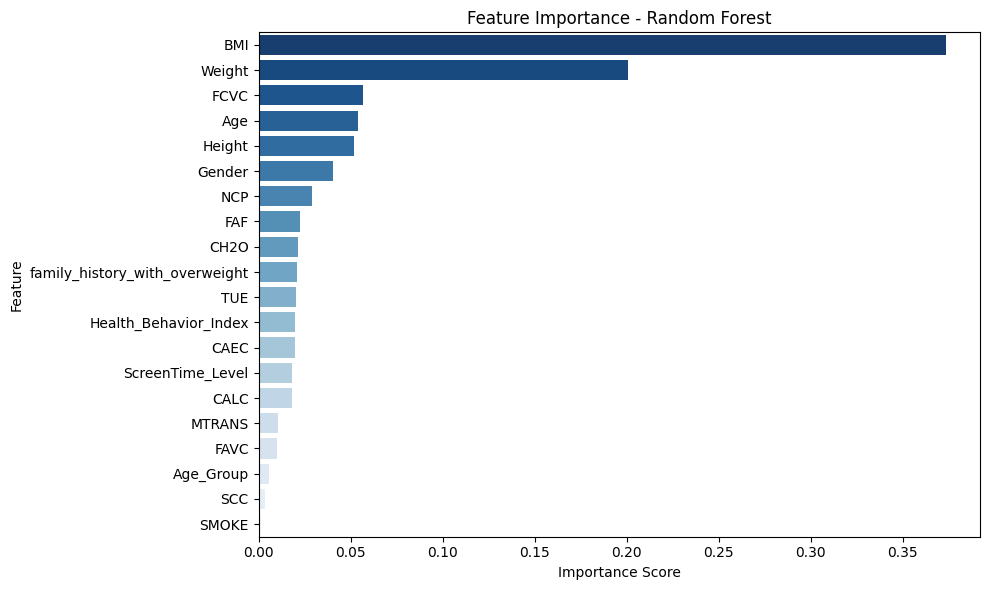

In [91]:
#@title Feature Importance

# Ambil nama fitur (pakai X, bukan X_scaled)
X = df.drop("NObeyesdad", axis=1) # Re-defining X to ensure it's available
feature_names = X.columns

# Ambil nilai feature importance dari model rf
importances = rf.feature_importances_

# Buat DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(
    data=fi_df,
    x="Importance",
    y="Feature",
    palette="Blues_r"
)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [92]:
#@title 11. DEEP LEARNING (MLP MODEL + CLASS WEIGHT)

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight

# Hitung Class Weight (dari data training)
classes = np.unique(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, class_weights))

print("Class Weight:", class_weight_dict)

# Arsitektur MLP
num_classes = len(df["NObeyesdad"].unique())
input_dim = X_train.shape[1]

model = keras.Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),  # Hidden layer 1
    Dropout(0.3),

    Dense(64, activation='relu'),   # Hidden layer 2
    Dropout(0.2),

    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training Model (class_weight)
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.15,
    class_weight=class_weight_dict,
    verbose=1
)
# Ringkasan Model
model.summary()


Class Weight: {np.int64(0): np.float64(1.1141522029372497), np.int64(1): np.float64(1.0596825396825398), np.int64(2): np.float64(0.8485002541942044), np.int64(3): np.float64(1.0060277275467149), np.int64(4): np.float64(0.9205736348593492), np.int64(5): np.float64(1.0788623141564317), np.int64(6): np.float64(1.0277093596059113)}
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2047 - loss: 1.9155 - val_accuracy: 0.4502 - val_loss: 1.7165
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3983 - loss: 1.6947 - val_accuracy: 0.4542 - val_loss: 1.4117
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4504 - loss: 1.4248 - val_accuracy: 0.5219 - val_loss: 1.1793
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5100 - loss: 1.2738 - val_accuracy: 0.6175 - val_loss: 1.0529
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5695 - loss: 1.0871 - val_accuracy: 0.6414 - val_loss: 0.9338
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6098 - loss: 1.0094 - val_accuracy: 0.6574 - val_loss: 0.8507
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6308 - loss: 0.9236 - val_accuracy: 0.7052 - val_loss: 0.7790
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6540 - loss: 0.8525 - val_accuracy: 0.7131 - val_loss: 0.7203
Epo

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,199 (133.59 KB)

 Trainable params: 11,399 (44.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,800 (89.07 KB)

In [93]:
print(input_dim)

20


In [94]:
#@title cek time pada MLP
start = time.time()
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.15,
    verbose=1
)
end = time.time()
print("Training time (MLP):", end - start, "seconds")


Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8592 - loss: 0.3370 - val_accuracy: 0.9363 - val_loss: 0.2289
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8835 - loss: 0.3156 - val_accuracy: 0.9402 - val_loss: 0.2079
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9118 - loss: 0.2851 - val_accuracy: 0.9363 - val_loss: 0.2067
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8930 - loss: 0.2839 - val_accuracy: 0.9602 - val_loss: 0.1944
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9092 - loss: 0.2789 - val_accuracy: 0.9283 - val_loss: 0.2089
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8813 - loss: 0.2909 - val_accuracy: 0.9323 - val_loss: 0.1915
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9142 - loss: 0.2730 - val_accuracy: 0.9163 - val_loss: 0.2061
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9002 - loss: 0.2646 - val_accuracy: 0.9402 - val_loss:

In [95]:
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,199 (133.59 KB)

 Trainable params: 11,399 (44.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,800 (89.07 KB)

In [96]:
#@title 12. EVALUASI DEEP LEARNING
y_pred_dl = np.argmax(model.predict(X_test), axis=1)

print("Deep Learning (MLP)")
print("Accuracy:", accuracy_score(y_test, y_pred_dl))
print(classification_report(y_test, y_pred_dl))


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Deep Learning (MLP)
Accuracy: 0.9234449760765551
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        53
           1       0.96      0.77      0.85        57
           2       0.95      0.99      0.97        70
           3       1.00      0.98      0.99        60
           4       1.00      1.00      1.00        65
           5       0.82      0.84      0.83        55
           6       0.85      0.90      0.87        58

    accuracy                           0.92       418
   macro avg       0.92      0.92      0.92       418
weighted avg       0.93      0.92      0.92       418



In [97]:
#@title Test Set Prediksi
sample_indices = list(range(10))  # ambil 10 data pertama

pred_table = pd.DataFrame({
    "Index": sample_indices,
    "Actual Label": y_test.values[:10],
    "Predicted Label": y_pred_dl[:10]
})

print(pred_table)


   Index  Actual Label  Predicted Label
0      0             6                6
1      1             2                2
2      2             4                4
3      3             5                5
4      4             2                2
5      5             2                2
6      6             2                2
7      7             6                6
8      8             4                4
9      9             3                3


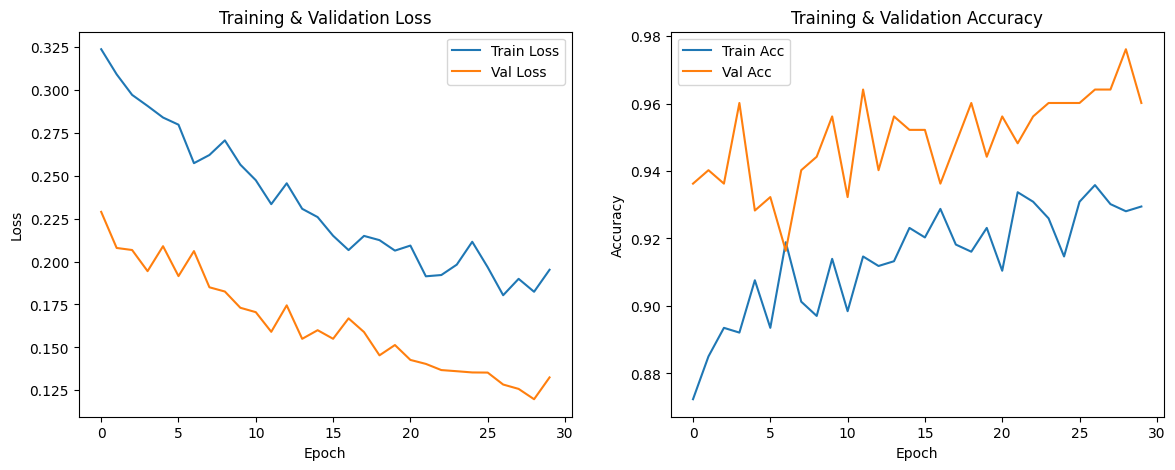

In [98]:
#@title 13. TRAINING PLOT MLP (Loss & Accuracy)

plt.figure(figsize=(14,5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


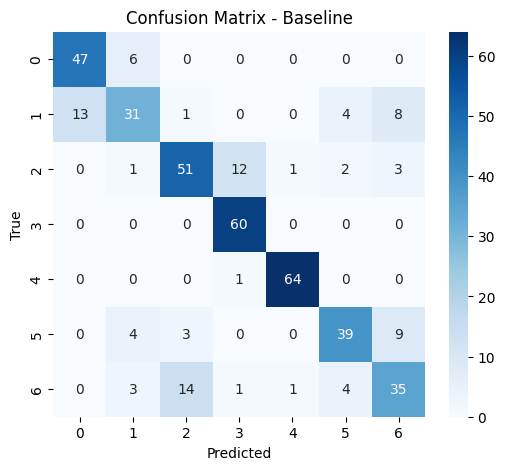

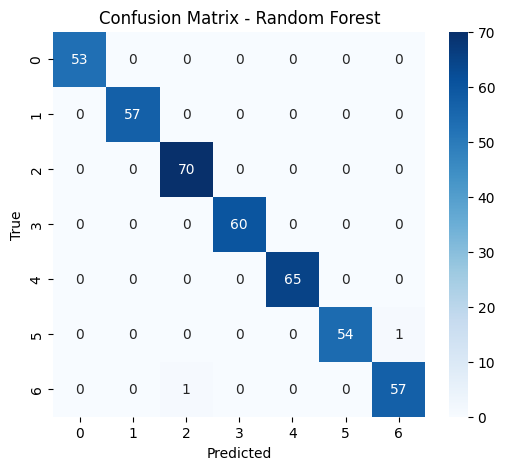

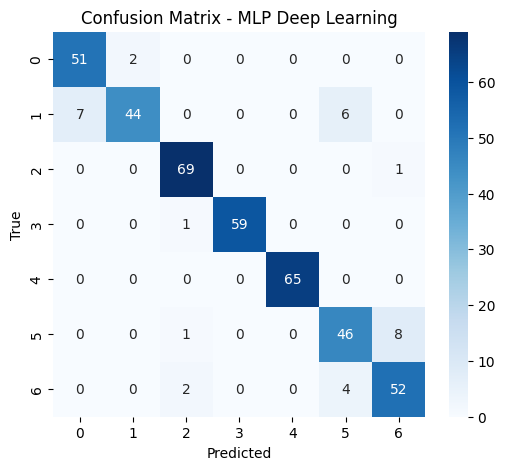

In [99]:
#@title 14. CONFUSION MATRIX UNTUK SEMUA MODEL

def plot_conf_matrix(y_true, y_pred, title):
    plt.figure(figsize=(6,5))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_conf_matrix(y_test, y_pred_base, "Confusion Matrix - Baseline")
plot_conf_matrix(y_test, y_pred_rf, "Confusion Matrix - Random Forest")
plot_conf_matrix(y_test, y_pred_dl, "Confusion Matrix - MLP Deep Learning")


In [100]:
#@title Table Perbandingan 3 Model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#hitung metriks secara otomatis
metrics = {
    "Model": ["Logistic Regression", "Random Forest", "MLP (Deep Learning)"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_base),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_dl)
    ],
    "Precision": [
        precision_score(y_test, y_pred_base, average='macro'),
        precision_score(y_test, y_pred_rf, average='macro'),
        precision_score(y_test, y_pred_dl, average='macro')
    ],
    "Recall": [
        recall_score(y_test, y_pred_base, average='macro'),
        recall_score(y_test, y_pred_rf, average='macro'),
        recall_score(y_test, y_pred_dl, average='macro')
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_base, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro'),
        f1_score(y_test, y_pred_dl, average='macro')
    ]
}

df_metrics = pd.DataFrame(metrics)
print(df_metrics)


                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.782297   0.774877  0.779483  0.773658
1        Random Forest  0.995215   0.995525  0.994940  0.995213
2  MLP (Deep Learning)  0.923445   0.922132  0.919451  0.918957


In [101]:
#@title Buat folder model untuk menyimpan pkl
import os

os.makedirs("models", exist_ok=True)


In [102]:
#@title Import untuk model pkl
import joblib

joblib.dump(baseline, "models/logistic_regression.pkl")
print("Logistic Regression model saved")


Logistic Regression model saved


In [103]:
joblib.dump(rf, "models/random_forest.pkl")
print("Random Forest model saved")


Random Forest model saved


In [104]:
model.save("models/mlp_model.keras")
print("MLP model saved")


MLP model saved


In [105]:
!ls models


logistic_regression.pkl  mlp_model.keras  random_forest.pkl
